# 学習過程の可視化

ここではチュートリアルで扱ったQNNClassifierとQNNRegressorにおいて、学習経過に従って学習が実際に進んでいく様子を可視化する.

まずインストールを行う.

In [30]:
!pip install skqulacs
!pip install qulacsvis
!pip install tqdm

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will n

## skqulacs.qnn.QNNClassifierについて学習過程の可視化

データを用意する.

In [31]:
from sklearn import datasets
iris = datasets.load_iris()

In [32]:
X = iris.data
T = iris.target

訓練データとテストデータに分ける.

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(0) # 乱数初期化を固定値に
train_x, test_x, train_t, test_t = train_test_split(X, T, train_size=0.8, test_size=0.2)
len(train_x), len(test_x), len(train_t), len(test_t) # サイズ表示

(120, 30, 120, 30)

訓練データをバッチに分ける.

In [34]:
batch_size = 4
batched_train_x_list = np.array_split(train_x, batch_size)
batched_train_t_list = np.array_split(train_t, batch_size)

量子回路を用意する.

In [35]:
from skqulacs.circuit.pre_defined import create_qcl_ansatz
from skqulacs.qnn import QNNClassifier
from skqulacs.qnn.solver import Bfgs

nqubit = 5                      # qubitの数。必要とする入力、出力の次元数以上が必要である。
c_depth = 3                     # circuitの深さ。ニューラルネットワークでの隠れ層に対応する。
time_step = 1.                  # qcl_ansatz に必要となるパラメータ。横磁場イジングモデルによって発展させる時間を決める。
num_class = 3                   # 分類数（ここでは3つの品種に分類）
solver = Bfgs()                   # アルゴリズム。ほかには、`Adam()` や `NelderMead()` が使える。
maxiter = 100                 # ループの最大。これが多いほど、正確になるが、時間がかかる。
circuit = create_qcl_ansatz(nqubit, c_depth, time_step)     # LearningCircuitを作る
qcl = QNNClassifier(circuit, num_class, solver)     # モデル構築を行う
#opt_loss, opt_params = qcl.fit(x_train, y_train, maxiter)

各エポックの学習が終わるごとにf1 scoreを出力する.

In [36]:
from tqdm import tqdm
from sklearn.metrics import f1_score
epoch = 5

opt_loss = [[0 for i in range(batch_size)] for i in range(epoch)]
for i in (range(epoch)):
  print("epoch", (i + 1))
  for j in tqdm(range(batch_size)):
    one_batch_train = batched_train_x_list[j]
    one_batch_test = batched_train_t_list[j]
    qcl.fit(one_batch_train, one_batch_test, maxiter)
  y_pred = qcl.predict(test_x)
  print("f1 score", f1_score(test_t, y_pred, average="weighted"))

epoch 1


100%|██████████| 4/4 [00:37<00:00,  9.33s/it]


f1 score 0.8885057471264368
epoch 2


100%|██████████| 4/4 [00:35<00:00,  8.86s/it]


f1 score 0.8885057471264368
epoch 3


100%|██████████| 4/4 [00:33<00:00,  8.44s/it]


f1 score 0.8885057471264368
epoch 4


100%|██████████| 4/4 [00:35<00:00,  8.82s/it]


f1 score 0.8885057471264368
epoch 5


100%|██████████| 4/4 [00:36<00:00,  9.01s/it]

f1 score 0.8885057471264368


## skqulacs.qnn.QNNRegressorの学習過程の可視化

データの生成を行う.

In [37]:
import numpy as np
from numpy.random import default_rng

def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi*x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    return np.array(x_train), np.array(y_train)
  
x_min = -1.0
x_max = 1.0
num_x = 80
x_train, y_train = generate_noisy_sine(x_min, x_max, num_x)
x_test, y_test = generate_noisy_sine(x_min, x_max, num_x)

量子回路を用意する. 学習の経過を可視化するために以下ではmaxiterを1にしており, 学習の効率自体はチュートリアルの時のものより下がっている.

In [38]:
from skqulacs.qnn import QNNRegressor

n_qubit = 4
depth = 6
time_step = 0.5
solver = Bfgs()
maxiter= 1 
circuit = create_qcl_ansatz(n_qubit, depth, time_step, 0)
qnn = QNNRegressor(circuit, solver)

iteration_num = 30 #iterationの回数
iterations = [i for i in range(iteration_num)] #回数
loss_values = [0 for i in range(iteration_num)] #opt_loss

for i in range(iteration_num):
  opt_loss, params_after = qnn.fit(x_train, y_train, maxiter)
  loss_values[i] = opt_loss

学習の経過に従って, 損失関数の値が減少していくことを描画する.

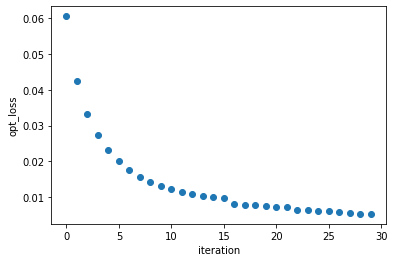

In [39]:
import matplotlib.pyplot as plt
plt.plot(iterations, loss_values, "o")
plt.xlabel("iteration")
plt.ylabel("opt_loss")
plt.show()